<a href="https://colab.research.google.com/github/Chris-Congleton/MSc-Thesis/blob/main/Analysis/2021_DataOverview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports


In [1]:
!pip install -U gensim
!pip install pyLDAvis
!pip install shap
!pip install datasets

import json, os
import pandas as pd
import numpy as np
import nltk
import glob
import matplotlib.pyplot as plt
import datetime
from tqdm import tqdm
nltk.download('punkt')

# regular expression library
import re
# wordcloud library
from wordcloud import WordCloud
import pprint

import gensim
from gensim.utils import simple_preprocess
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('dutch')

import gensim.corpora as corpora

import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis

#Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction                      
import IPython

from gensim.parsing.preprocessing import preprocess_string
from gensim import utils
import gensim.models

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier

import shap
import datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 49.0 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 7.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=3c01b03ee1f86aa7ee1d6579d413c4ee5bcc305e823056603fc41594f8c518f9
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
/usr/local/lib/python3.7/dist-packages/numba/core/types/__init__.py:108: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on 

# Loading and cleaning data

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
!dir gdrive/MyDrive/CS/Thesis/Testset_2021/

HetParool_2021.json  LDA_HetParool.png	LDA_Trouw.png
LDA_all.html	     LDA__.html		LDA_Volkskrant.html
LDA_All.html	     LDA_NRC.html	NRC_2021.json
LDA_all.png	     LDA_NRC.png	Telegraaf_2021.json
LDA_All.png	     LDA__.png		Trouw_2021.json
LDA_HetParool.html   LDA_Trouw.html	Volkskrant_2021.json


In [4]:
path_NRC = 'gdrive/MyDrive/CS/Thesis/Testset_2021/NRC_2021.json'
path_Trouw = 'gdrive/MyDrive/CS/Thesis/Testset_2021/Trouw_2021.json'
path_HetParool = 'gdrive/MyDrive/CS/Thesis/Testset_2021/HetParool_2021.json'
path_Telegraaf = 'gdrive/MyDrive/CS/Thesis/Testset_2021/Telegraaf_2021.json'
path_Volkskrant = 'gdrive/MyDrive/CS/Thesis/Testset_2021/Volkskrant_2021.json'

In [5]:
df_NRC = pd.read_json(path_NRC)
df_Trouw = pd.read_json(path_Trouw)
df_HetParool = pd.read_json(path_HetParool)
df_Telegraaf = pd.read_json(path_Telegraaf)
df_Volkskrant = pd.read_json(path_Volkskrant)

In [6]:
df_NRC["Source"] = "NRC"
df_Trouw["Source"] = "Trouw"
df_HetParool["Source"] = "HetParool"
df_Telegraaf["Source"] = "Telegraaf"
df_Volkskrant["Source"] = "Volkskrant"

In [7]:
print(df_NRC.shape)
print(df_Trouw.shape)
print(df_HetParool.shape)
print(df_Volkskrant.shape)

(38334, 7)
(21077, 7)
(18551, 7)
(25773, 7)


## Concat data

In [51]:

dfs = [df_NRC, df_Trouw, df_HetParool, df_Volkskrant]
df = pd.concat(dfs, ignore_index=True)

df.head()

,url,timestamp,title,publisherID,cleantext,category,Source
0,https://www.nrc.nl/nieuws/2021/01/31/een-herha...,2021-01-31 20:18:43,Een herhaling van vorig seizoen is zo goed als...,Fabian van der Poll,De eerste maand van 2021 is uitstekend verlope...,None,NRC
1,https://www.nrc.nl/nieuws/2021/01/31/avondklok...,2021-01-31 20:02:10,‘Avondklok waarschijnlijk niet verlengd als be...,Steven Musch,De avondklok wordt waarschijnlijk niet verleng...,None,NRC
2,https://www.nrc.nl/nieuws/2021/01/31/school-op...,2021-01-31 19:58:21,"School open? Dan testen, ventilatie en mondkapjes",Karel Berkhout,Door de heropening van de scholen loopt het aa...,None,NRC
3,https://www.nrc.nl/nieuws/2021/01/31/scholen-o...,2021-01-31 19:45:18,"De basisscholen gaan open, met een paar nieuwe...",Claudia Kammer,"Het werd alom verwacht, en zondag aan het ei...",None,NRC
4,https://www.nrc.nl/nieuws/2021/01/31/arrestati...,2021-01-31 19:43:49,Arrestatie Russische betoger,None,,None,NRC


In [52]:
df['Source'].value_counts()

NRC           38334
Volkskrant    25773
Trouw         21077
HetParool     18551
Name: Source, dtype: int64

In [10]:
df.shape

(103735, 7)

## Remove missing text

In [53]:
print(df.shape)
df = df[df['cleantext'].str.len()>5]
print(df.shape)

(103735, 7)
(96840, 7)


In [54]:
df['Source'].value_counts()

NRC           32043
Volkskrant    25702
Trouw         20944
HetParool     18151
Name: Source, dtype: int64

In [55]:
df_sourcecount = df['Source'].value_counts().reset_index().rename(columns={'index':'Source', 'Source':'Number of Articles'})
df_sourcecount = df_sourcecount.sort_values(by='Source')
df_sourcecount.head()

,Source,Number of Articles
3,HetParool,18151
0,NRC,32043
2,Trouw,20944
1,Volkskrant,25702


In [61]:
df['Source'] = pd.Categorical(df['Source'], ['NRC','Volkskrant','Trouw','HetParool'])

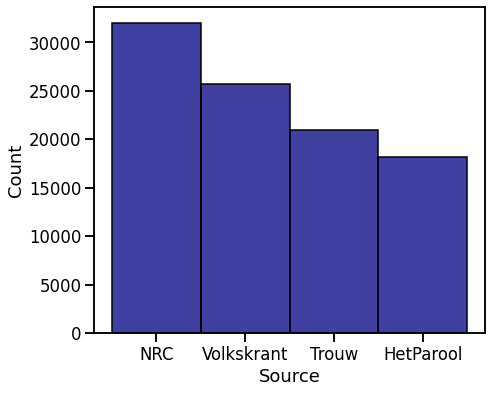

In [62]:
# bigger plot elements suitable for giving talks
sns.set_context("talk")
# set figure size
plt.figure(figsize=(7,6))
# Time series plot with Seaborn lineplot()
sns.histplot(x=df.Source, color="navy")
#sns.color_palette("hls", 8)
# axis labels
#plt.title("Total Newspaper Articles")

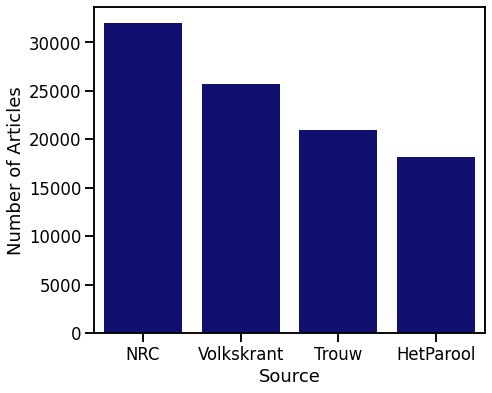

In [57]:
# bigger plot elements suitable for giving talks
sns.set_context("talk")
# set figure size
plt.figure(figsize=(7,6))
# Time series plot with Seaborn lineplot()
sns.barplot(x=df_sourcecount.Source, y=df_sourcecount['Number of Articles'], color="navy")
#sns.color_palette("hls", 8)
# axis labels
#plt.title("Total Newspaper Articles")

In [15]:
df['nwords'] = df.cleantext.str.len()
df.head()

df_nwords = df.groupby(by='Source').sum('nwords').reset_index().rename(columns={'nwords':'Number of Words'})
df_nwords = df_nwords.sort_values(by='Source')
df_nwords.head()

,Source,Number of Words
0,HetParool,59113961
1,NRC,103552942
2,Trouw,69744897
3,Volkskrant,102497142


In [32]:
df_nwords['Source'] = pd.Categorical(df_nwords['Source'], ['NRC','Volkskrant','Trouw','HetParool'])

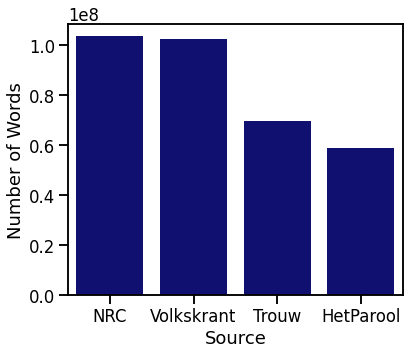

In [33]:
# bigger plot elements suitable for giving talks
sns.set_context("talk")
# set figure size
plt.figure(figsize=(6,5))
# Time series plot with Seaborn lineplot()
sns.barplot(x=df_nwords.Source, y=df_nwords['Number of Words'], color="navy")

In [17]:
df_both = df_sourcecount.merge(df_nwords, on='Source')
df_both.head()

,Source,Number of Articles,Number of Words
0,HetParool,18151,59113961
1,NRC,32043,103552942
2,Trouw,20944,69744897
3,Volkskrant,25702,102497142


In [18]:
df_both = df_both.melt("Source")


In [19]:
df_both.head()

,Source,variable,value
0,HetParool,Number of Articles,18151
1,NRC,Number of Articles,32043
2,Trouw,Number of Articles,20944
3,Volkskrant,Number of Articles,25702
4,HetParool,Number of Words,59113961


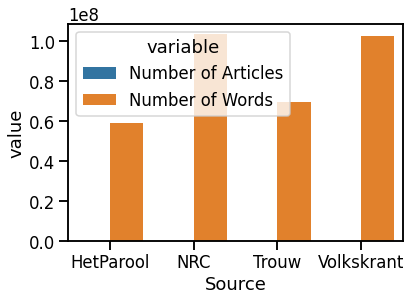

In [20]:
# bigger plot elements suitable for giving talks
sns.set_context("talk")
# set figure size
#plt.figure(figsize=(6,5))
# Time series plot with Seaborn lineplot()
sns.barplot(x=df_both.Source, y=df_both.value, hue=df_both.variable)

In [40]:
articles = df

In [41]:
# Remove punctuation
articles['cleantext_processed'] = articles['cleantext'].map(lambda x: re.sub('[,\\.!?]', '', x))
# Save D66
articles['cleantext_processed'] = articles['cleantext_processed'].map(lambda x: re.sub('D66', 'dzeszes', x))
# Save BIJ1
articles['cleantext_processed'] = articles['cleantext_processed'].map(lambda x: re.sub('BIJ1', 'bijeeen', x))
# Save 50PLUS
articles['cleantext_processed'] = articles['cleantext_processed'].map(lambda x: re.sub('50Plus', 'vijfplus', x))
# Save JA21
articles['cleantext_processed'] = articles['cleantext_processed'].map(lambda x: re.sub('JA21', 'jatweeeen', x))
# Save DenHaan
articles['cleantext_processed'] = articles['cleantext_processed'].map(lambda x: re.sub('Den Haan', 'denhaan', x))
# Convert the titles to lowercase
articles['cleantext_processed'] = articles['cleantext_processed'].map(lambda x: x.lower())

p_and_p =  ['vvd', 'dzeszes', 'pvv', 'cda', 'pvda', 'sp', 'gl', 'fvd', 'pvdd',
            'cu', 'sgp', 'volt', 'jatweeeen', 'bbb', 'bijeeen', 'vijfplus', 'rutte', 'kaag',
            'wilders', 'hoekstra', 'ploumen', 'marijnissen', 'klaver', 'baudet',
            'ouwehand', 'segers', 'staaij', 'dassen', 'eerdmans', 'plas',
            'simons', 'denhaan']


pat = '|'.join(r"\b{}\b".format(x) for x in p_and_p)
articles = articles[articles['cleantext_processed'].str.contains(pat)]
print(articles.shape)

(15508, 9)


In [42]:
articles.head()

,url,timestamp,title,publisherID,cleantext,category,Source,nwords,cleantext_processed
1,https://www.nrc.nl/nieuws/2021/01/31/avondklok...,2021-01-31 20:02:10,‘Avondklok waarschijnlijk niet verlengd als be...,Steven Musch,De avondklok wordt waarschijnlijk niet verleng...,None,NRC,972,de avondklok wordt waarschijnlijk niet verleng...
3,https://www.nrc.nl/nieuws/2021/01/31/scholen-o...,2021-01-31 19:45:18,"De basisscholen gaan open, met een paar nieuwe...",Claudia Kammer,"Het werd alom verwacht, en zondag aan het ei...",None,NRC,4361,het werd alom verwacht en zondag aan het ein...
6,https://www.nrc.nl/nieuws/2021/01/31/alles-wan...,2021-01-31 19:35:29,Alles wantrouwen,Stephan Sanders,Het grote wantrouwen tegen de overheid spuit e...,Opinie,NRC,2125,het grote wantrouwen tegen de overheid spuit e...
15,https://www.nrc.nl/nieuws/2021/01/31/stel-dat-...,2021-01-31 17:03:22,Stel dat de zee opeens twee meter stijgt,Arjen Schreuder,Lang is gedacht dat de stijging van de zeespie...,None,NRC,7234,lang is gedacht dat de stijging van de zeespie...
22,https://www.nrc.nl/nieuws/2021/01/31/minister-...,2021-01-31 15:16:18,Minister Slob: basisscholen en kinderopvang 8 ...,Simone Peek,De basisscholen en kinderopvang gaan vanaf maa...,None,NRC,1169,de basisscholen en kinderopvang gaan vanaf maa...


In [43]:
articles['Source'] = pd.Categorical(articles['Source'], ['NRC','Volkskrant','Trouw','HetParool'])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


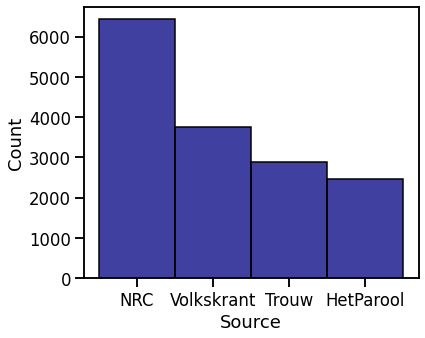

In [49]:
# bigger plot elements suitable for giving talks
sns.set_context("talk")
# set figure size
plt.figure(figsize=(6,5))
# Time series plot with Seaborn lineplot()
sns.histplot(x=articles.Source, color="navy")

In [28]:
df_sourcecount = articles['Source'].value_counts().reset_index().rename(columns={'index':'Source', 'Source':'Number of Articles'})
df_sourcecount = df_sourcecount.sort_values(by='Number of Articles')
df_sourcecount.head()

,Source,Number of Articles
3,HetParool,2454
2,Trouw,2877
1,Volkskrant,3752
0,NRC,6425


In [45]:
articles['nwords'] = articles.cleantext.str.len()

df_nwords = articles.groupby(by='Source').sum('nwords').reset_index().rename(columns={'nwords':'Number of Words'})
df_nwords = df_nwords.sort_values(by='Source')
df_nwords.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Source,Number of Words
0,NRC,29400037
1,Volkskrant,19363475
2,Trouw,11574255
3,HetParool,10209719


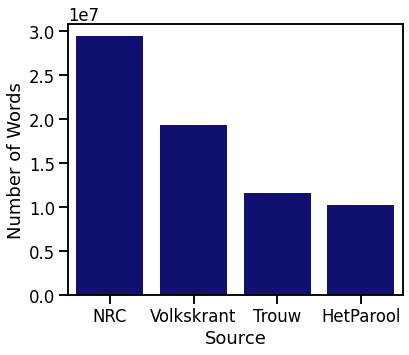

In [48]:
# bigger plot elements suitable for giving talks
sns.set_context("talk")
# set figure size
plt.figure(figsize=(6,5))
# Time series plot with Seaborn lineplot()
sns.barplot(x=df_nwords.Source, y=df_nwords["Number of Words"], color="navy")